# Drift with Brownian Motion

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from shapely.geometry import Polygon

## Load Border Geometry Data

In [14]:
df = pd.read_csv("central_america_border_nodes_with_velocity_normal.csv")

# Add a vertex index (preserving the order in which they appear)
df = df.reset_index().rename(columns={"index": "vertex_index"})

# Group the vertices by country. We assume the rows for each country are in order.
countries = df['country'].unique()
# Create two dictionaries:
#   - initial_polys: maps country to an array of vertices (in order)
#   - drift_vectors: maps country to the average velocity normal vector (we assume it's the same for all vertices of that country)
initial_polys = {}
drift_vectors = {}

for country in countries:
    sub = df[df["country"] == country].copy()
    # If the CSV rows are in the proper order, we simply use their order index.
    sub = sub.sort_values("vertex_index")
    coords = sub[["longitude", "latitude"]].to_numpy()
    initial_polys[country] = coords
    # Use the first row's vnorm as the country’s velocity normal.
    vnorm = sub.iloc[0][["vnorm_x", "vnorm_y"]].to_numpy()
    # Normalize the velocity normal
    norm_val = np.linalg.norm(vnorm)
    if norm_val > 0:
        drift_vectors[country] = vnorm / norm_val
    else:
        drift_vectors[country] = np.array([1.0, 0.0])

## Set up Drift Parameters 

In [15]:
num_days = 730  # 2 years (daily updates)

# Goal is total drift of 200 miles. Since 1 degree of latitude is roughly 69 miles,
# the total drift in degrees is approximately 200/69.
total_drift_degrees = 200 / 69  # ~0.7246 degrees total displacement over 730 days
daily_drift_magnitude = total_drift_degrees / num_days  # constant drift per day

# Brownian motion noise parameter (in degrees)
sigma = 0.005

## Run the Simulation

In [16]:
# We'll store, for each country, a list of vertex arrays (one per day).
trajectories = {}    # country -> list of np.array, each shape (num_vertices, 2)
# Also store cumulative translation vectors for each country over time.
cumulative_translations = {}

# Initialize each country with its starting configuration.
for country in countries:
    initial = initial_polys[country]
    trajectories[country] = [initial]  # day 0 positions
    cumulative_translations[country] = [np.array([0.0, 0.0])]  # zero translation at start

# Set random seed for reproducibility.
np.random.seed(42)

# Perform simulation for each day.
for day in range(1, num_days + 1):
    for country in countries:
        prev_trans = cumulative_translations[country][-1]
        # Compute deterministic drift.
        unit_drift = drift_vectors[country]  # already normalized
        drift_step = unit_drift * daily_drift_magnitude
        # Compute Brownian noise (sampled independently on x and y).
        noise = np.random.normal(0, sigma, size=2)
        # Total step is deterministic drift plus noise.
        step = drift_step + noise
        new_trans = prev_trans + step
        cumulative_translations[country].append(new_trans)
        # Update vertices positions by adding the new translation to the original vertices.
        new_positions = initial_polys[country] + new_trans
        trajectories[country].append(new_positions)

## Visualize Country Positions Over Time

/var/folders/2f/7sxq51rj0xd8mgyvzzj2tgy80000gn/T/ipykernel_67519/979922928.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("tab10", len(countries))


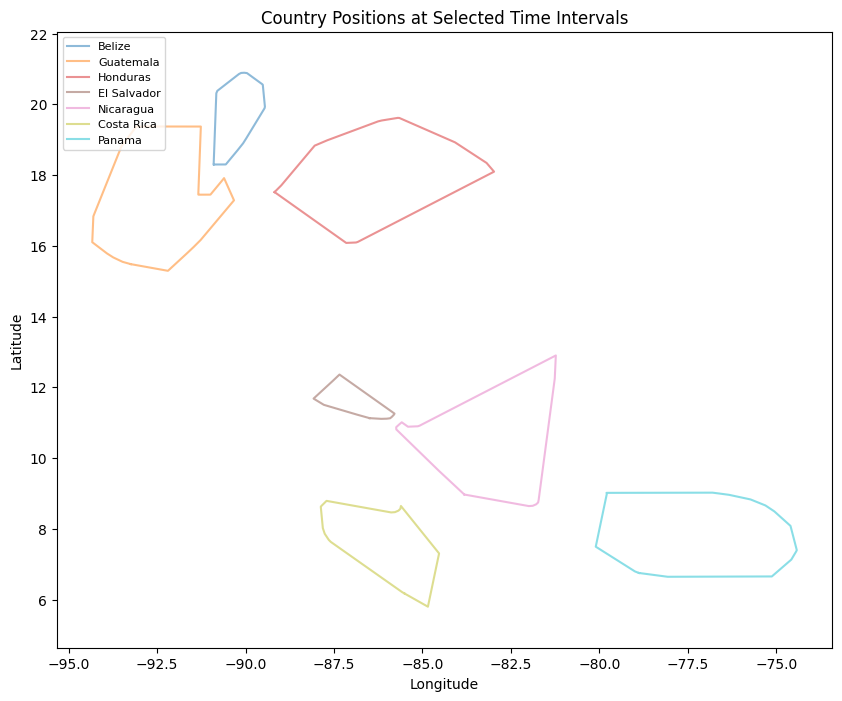

In [ ]:
plot_days = [0, 182, 365, 547, 730]  # e.g., initial, ~6 months, 1 year, 1.5 years, 2 years

fig, ax = plt.subplots(figsize=(10, 8))
cmap = cm.get_cmap("tab10", len(countries))

for i, country in enumerate(countries):
    color = cmap(i)
    # Plot the polygon positions at each selected day.
    for d in plot_days:
        coords = trajectories[country][d]
        poly = Polygon(coords)
        ax.plot(*poly.exterior.xy, color=color, alpha=0.5,
                label=country if d == plot_days[0] else "")
ax.set_title("Country Positions at Selected Time Intervals")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.axis("equal")
ax.legend(fontsize=8, loc="upper left")
plt.show()

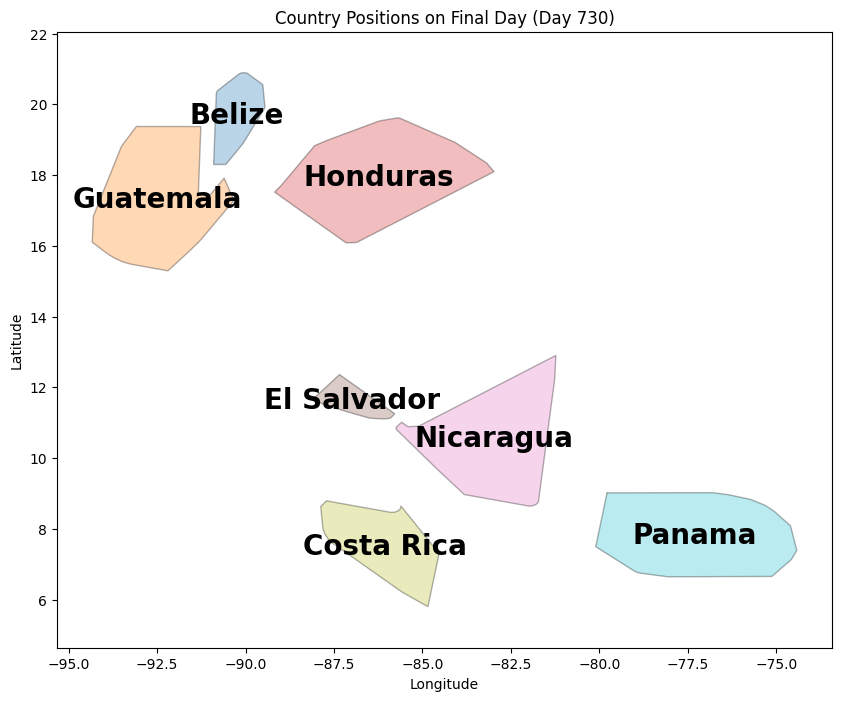

In [21]:
fig, ax = plt.subplots(figsize=(10, 8))
cmap = plt.get_cmap("tab10", len(countries))

# Loop over each country.
for i, country in enumerate(countries):
    # Get the last day's coordinates from the simulation.
    coords = trajectories[country][-1]
    poly = Polygon(coords)
    
    # Plot the polygon with light shading.
    patch = plt.Polygon(coords, facecolor=cmap(i), edgecolor='k', alpha=0.3)
    ax.add_patch(patch)
    
    # Compute the centroid to place the label.
    centroid = poly.centroid
    ax.text(centroid.x, centroid.y, country,
            fontsize=20, fontweight='bold',
            ha='center', va='center', color='black')

ax.set_title("Country Positions on Final Day (Day 730)")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.axis("equal")
plt.show()

## Save Daily Positions as CSV

In [18]:
csv_rows = []
for country in countries:
    num_vertices = initial_polys[country].shape[0]
    for day, positions in enumerate(trajectories[country]):
        for vi in range(num_vertices):
            lon, lat = positions[vi]
            csv_rows.append({
                "day": day,
                "country": country,
                "vertex_index": vi,
                "longitude": lon,
                "latitude": lat
            })

df_positions = pd.DataFrame(csv_rows)
csv_filename = "drift_simulation_daily_positions.csv"
df_positions.to_csv(csv_filename, index=False)
print(f"CSV saved: {csv_filename}")

CSV saved: drift_simulation_daily_positions.csv
